In [82]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from math import sqrt
import shap
import numpy as np

In [147]:
def random_forest_forecast(train, X_test):
    y_train = train['num_crimes']
    train_dates = train['date']
    X_train = train.drop(columns=['num_crimes', 'date'])

    model = RandomForestRegressor(n_estimators=500)
    model.fit(X_train, y_train)

    yhat = model.predict(pd.DataFrame(X_test))
    return yhat[0]


def walk_forward_validation(train_data, test_data):
    predictions = []

    train = train_data
    test = test_data

    history = train


    for i in range(len(test)):
  
        y_test = test['num_crimes'].iloc[i]
        X_test = test.iloc[i]
        X_test = X_test.drop(['num_crimes', 'date'])
        X_test = pd.DataFrame(X_test).transpose()

        yhat = random_forest_forecast(history, X_test)

        predictions.append(yhat)

        X_test['num_crimes'] = yhat
        history = pd.concat([history, X_test])

        print('>expected=%.1f, predicted=%.1f' % (y_test, yhat))

    error = mean_squared_error(test['num_crimes'], predictions)
    return error, test['num_crimes'], predictions

In [148]:
day_data = pd.read_csv('../day_data.csv')
day_data['date'] = pd.to_datetime(day_data['date'], format="%Y-%m-%d")
day_data['holiday'] = day_data['holiday'].fillna('0')

onehot = OneHotEncoder(categories='auto', drop=None, sparse_output=False)
holidays = onehot.fit_transform(day_data[['holiday']])
holidays = pd.DataFrame(holidays, columns=onehot.categories_)

onehot = OneHotEncoder(categories='auto', drop='first', sparse_output=False)
wd = onehot.fit_transform(day_data[['wd']])
wd = pd.DataFrame(wd, columns=onehot.get_feature_names_out(['wd']))

day_data = pd.concat([day_data, holidays, wd], axis=1)
day_data = day_data.drop(columns=['holiday', ('0',), 'wd'])
day_data.columns = day_data.columns.astype(str)

cutoff_date = '2024-01-01'

In [149]:
train_data = day_data[day_data['date'] < cutoff_date]
train_data['x1'] = train_data['num_crimes'].shift(1)
train_data['x2'] = train_data['num_crimes'].shift(2)
train_data['x3'] = train_data['num_crimes'].shift(3)
train_data = train_data.ffill().bfill().ffill()
train_dates = train_data['date']

y_train = train_data['num_crimes']
X_train = train_data.drop(columns=['num_crimes', 'date'])


test_data = day_data[(day_data['date'] >= cutoff_date) & (day_data['date'] <= '2024-01-31')]
test_data['x1'] = test_data['num_crimes'].shift(1)
test_data['x2'] = test_data['num_crimes'].shift(2)
test_data['x3'] = test_data['num_crimes'].shift(3)
test_data = test_data.ffill().bfill().ffill()
y_test = test_data['num_crimes']
test_dates = test_data['date']
X_test = test_data.drop(columns=['num_crimes', 'date'])

C:\Users\benke\AppData\Local\Temp\ipykernel_636\2676617810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['x1'] = train_data['num_crimes'].shift(1)
C:\Users\benke\AppData\Local\Temp\ipykernel_636\2676617810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['x2'] = train_data['num_crimes'].shift(2)
C:\Users\benke\AppData\Local\Temp\ipykernel_636\2676617810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [150]:
mse, ytrue, yhat = walk_forward_validation(train_data, test_data)

>expected=49.0, predicted=42.8
>expected=35.0, predicted=43.0


KeyboardInterrupt: 

In [89]:
print(f'MAE: {mean_absolute_error(ytrue, yhat)}')
print(f'RMSE: {np.sqrt(mse)}')

plt.plot(test_dates, ytrue, label='Actual', color='black')
plt.plot(test_dates, yhat, label='Predicted', color='red')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('# of Daily Crimes Reported')
plt.title('Predicted vs. Actual Daily Crimes Reported in January, 2024')
plt.legend()
plt.grid(visible=False)
plt.show()

MAE: 4.554045725795755
RMSE: 5.473275005784114


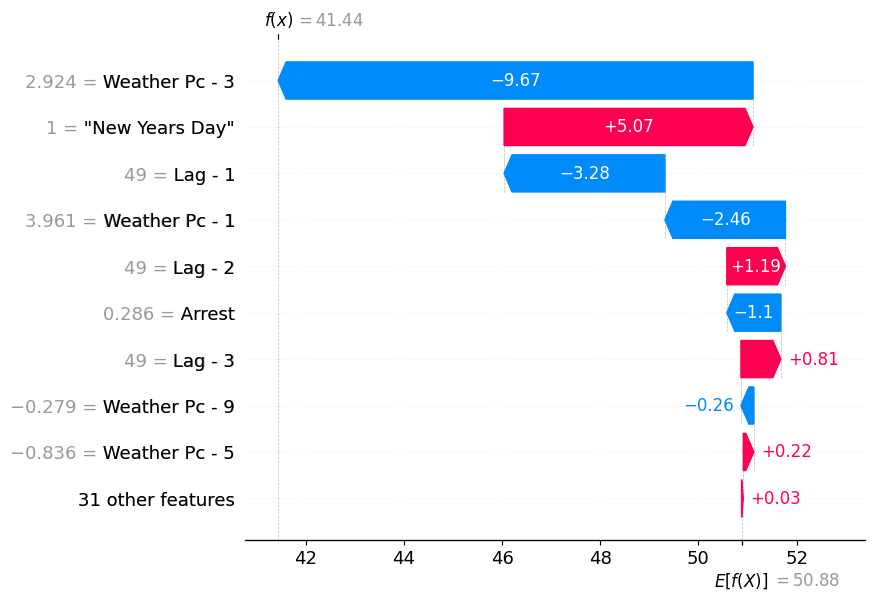

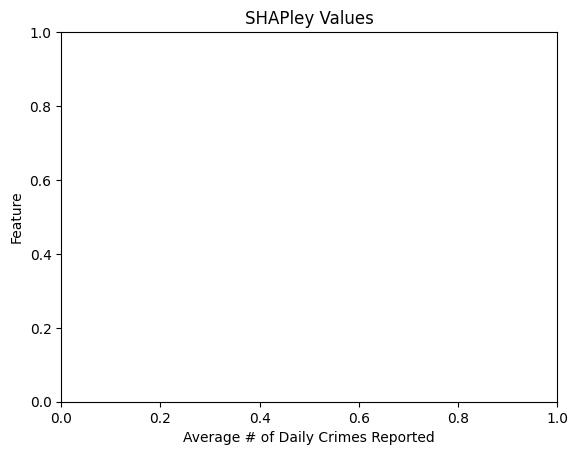

In [146]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

cleaned_columns = []
for col in X_train.columns:
    clean_col = col.replace('wd_', '')
    clean_col = clean_col.replace('(', '').replace(')', '').replace("'", "").replace(',','')
    clean_col = clean_col.strip()
    clean_col = clean_col.title().replace('_', ' ')
    clean_col = clean_col.replace('Wpc', 'Weather PC - ')
    clean_col = clean_col.replace('X', 'Lag - ')
    cleaned_columns.append(clean_col)
X_train.columns = cleaned_columns
X_test.columns = cleaned_columns

explainer = shap.TreeExplainer(rf_model)
explainer.feature_names = X_train.columns
sv = explainer(X_test)
shap.plots.waterfall(sv[0])
plt.title('SHAPley Values')